# Import

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
from numpy.fft import fft

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

plt.rcParams["figure.figsize"] = (30, 20)

# Function

In [8]:
## process_file() takes a string with a path to the .csv
def process_file(pathname):
    res = pd.read_csv(pathname, sep = ',', header = 0, index_col = None, names = ['time', 'seconds', 'z', 'y', 'x'])
    # res = res[(res['seconds'] >= 15) & (res['seconds'] <=25)]
    return res

## butterworth() takes a dataframe with our accelerometer data and applies the Butterworth filter to it. 
## The columns of the DF is overwritten by the filtered values.
## Sources: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html 
##               https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
def butterworth(df):
    nyquist_frequency = 0.5 * 50
    
    low = 0.5 / nyquist_frequency
    high = 3.0 / nyquist_frequency
    
    b, a = signal.butter(3, Wn=[low, high], btype='bandpass')

    df['x'] = signal.filtfilt(b, a, df['x'])
    df['y'] = signal.filtfilt(b, a, df['y'])
    df['z'] = signal.filtfilt(b, a, df['z'])

    return df

## fourier() takes a dataframe with our filtered accelerometer data and produces a new dataframe with x, y pairs.
## This produces the Fourier-transformed data. (I assume)
## Sources: https://stackoverflow.com/questions/66675657/fast-fourier-transform-for-an-accelerometer-in-python
def fourier(df):
    yf = np.abs(fft(df['x'] + df['y'] + df['z']))
    xf = np.linspace(0, 50, len(yf))

    return pd.DataFrame(zip(xf, yf), columns = ['x', 'y'])

## to_row() takes a Fourier-transformed dataframe and transposes its 'y' column into a row.
## This makes it possible to pass the transformed dataframe into an ML model.
def to_row(df, name):
    df = df.T
    df.drop('x', inplace = True)
    df.reset_index(drop = True, inplace = True)
    df.insert(loc = 0, column = 'Name', value = name)

    return df


In [9]:
# Processing .csv files, passing them through Butterworth filter, and Fourier transforming them

# Matt right pocket screen on/off
# trim raw file
matt_rp50_screen_off = process_file('data/matt_rp50_1min_screenoff.csv')
matt_rp50_screen_on = process_file('data/matt_rp50_1min_screeon.csv')

# butterworth filter (bw)
matt_rp50_screen_off_bw = butterworth(matt_rp50_screen_off)
matt_rp50_screen_on_bw = butterworth(matt_rp50_screen_on)

# fourier transform(fft)
#   raw_fft
matt_rp50_screen_off_fft = fourier(matt_rp50_screen_off)
matt_rp50_screen_on_fft = fourier(matt_rp50_screen_on)
#   bw_fft
matt_rp50_screen_off_bw_fft = fourier(matt_rp50_screen_off_bw)
matt_rp50_screen_on_bw_fft = fourier(matt_rp50_screen_on_bw)

# Raw Plot

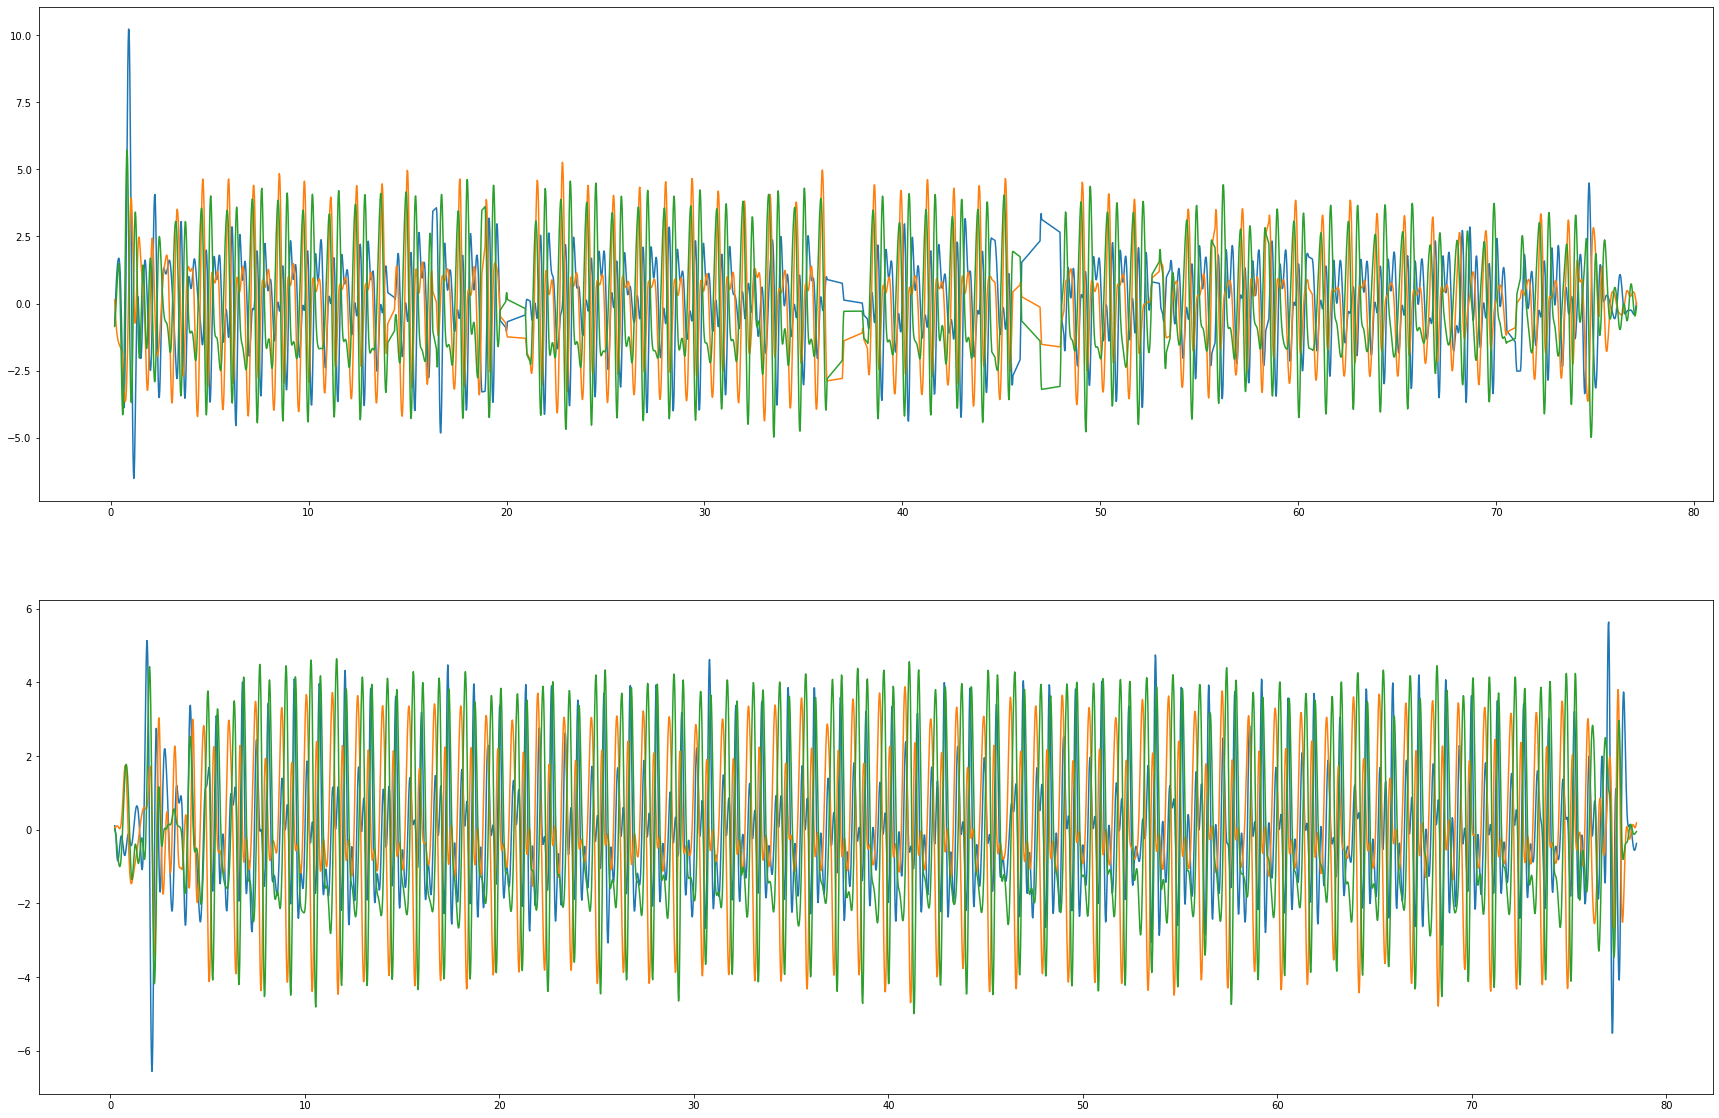

In [10]:
# Plotting Butterworth filtered data. Each line represents an axis.
fig, ax = plt.subplots(2)

# screen off plot
ax[0].plot(matt_rp50_screen_off['seconds'], matt_rp50_screen_off['x'])
ax[0].plot(matt_rp50_screen_off['seconds'], matt_rp50_screen_off['y'])
ax[0].plot(matt_rp50_screen_off['seconds'], matt_rp50_screen_off['z'])

# Matt
# screen on plot
ax[1].plot(matt_rp50_screen_on['seconds'], matt_rp50_screen_on['x'])
ax[1].plot(matt_rp50_screen_on['seconds'], matt_rp50_screen_on['y'])
ax[1].plot(matt_rp50_screen_on['seconds'], matt_rp50_screen_on['z'])



# Butterworth Filter

Compare the screeen on/off plot, we can see that when we record the screen off data, the device may ask the app to sleep down in a regular pattern.
So the data is going to be inaccurate with screen off.

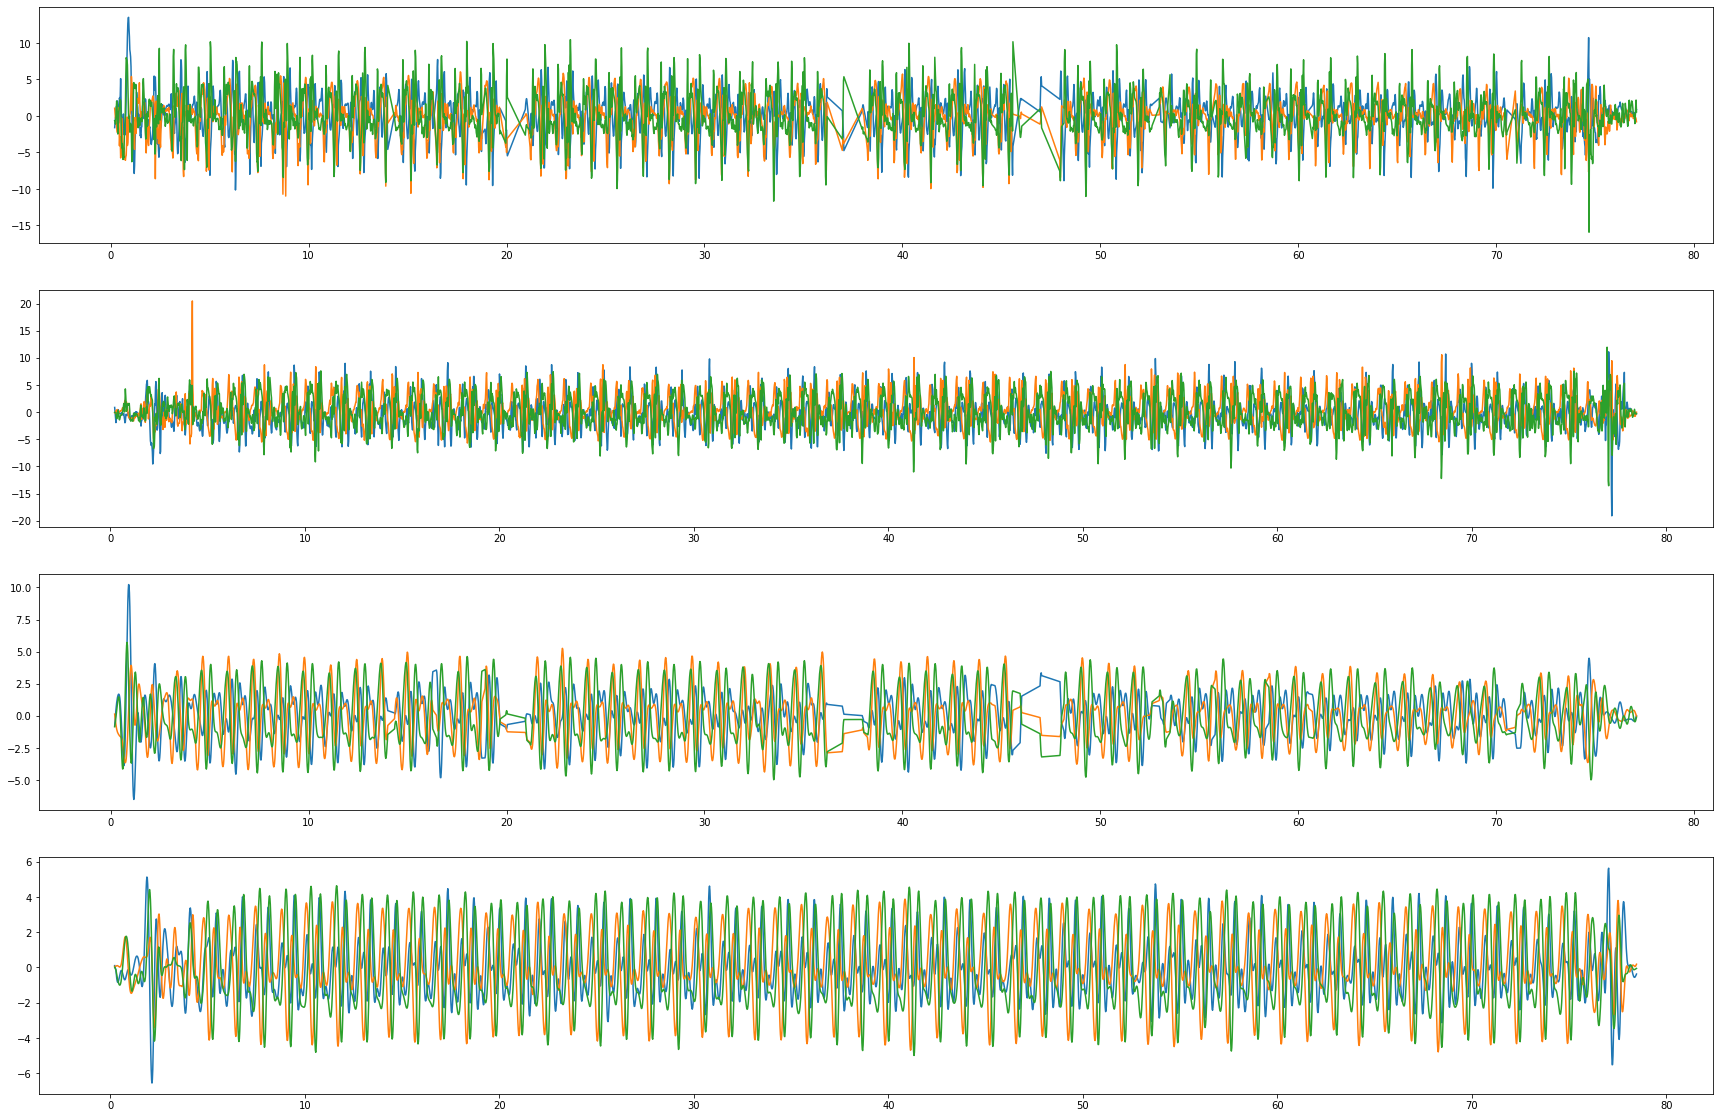

In [11]:
fig, ax = plt.subplots(4)

matt_rp50_screen_off = process_file('data/matt_rp50_1min_screenoff.csv')
matt_rp50_screen_on = process_file('data/matt_rp50_1min_screeon.csv')

# screen off raw data plot
ax[0].plot(matt_rp50_screen_off['seconds'], matt_rp50_screen_off['x'])
ax[0].plot(matt_rp50_screen_off['seconds'], matt_rp50_screen_off['y'])
ax[0].plot(matt_rp50_screen_off['seconds'], matt_rp50_screen_off['z'])

# screen on raw data plot
ax[1].plot(matt_rp50_screen_on['seconds'], matt_rp50_screen_on['x'])
ax[1].plot(matt_rp50_screen_on['seconds'], matt_rp50_screen_on['y'])
ax[1].plot(matt_rp50_screen_on['seconds'], matt_rp50_screen_on['z'])

matt_rp50_screen_off_bw = butterworth(matt_rp50_screen_off)
matt_rp50_screen_on_bw = butterworth(matt_rp50_screen_on)

# bw screen off bw filtered data plot
ax[2].plot(matt_rp50_screen_off_bw['seconds'], matt_rp50_screen_off_bw['x'])
ax[2].plot(matt_rp50_screen_off_bw['seconds'], matt_rp50_screen_off_bw['y'])
ax[2].plot(matt_rp50_screen_off_bw['seconds'], matt_rp50_screen_off_bw['z'])

# bw screen on bw filtered data plot
ax[3].plot(matt_rp50_screen_on_bw['seconds'], matt_rp50_screen_on_bw['x'])
ax[3].plot(matt_rp50_screen_on_bw['seconds'], matt_rp50_screen_on_bw['y'])
ax[3].plot(matt_rp50_screen_on_bw['seconds'], matt_rp50_screen_on_bw['z'])






# Fourier Transform

Whether data has been filterd or not, it doesn't  really affect the result of the Fourier Transform

(0.0, 1.0)

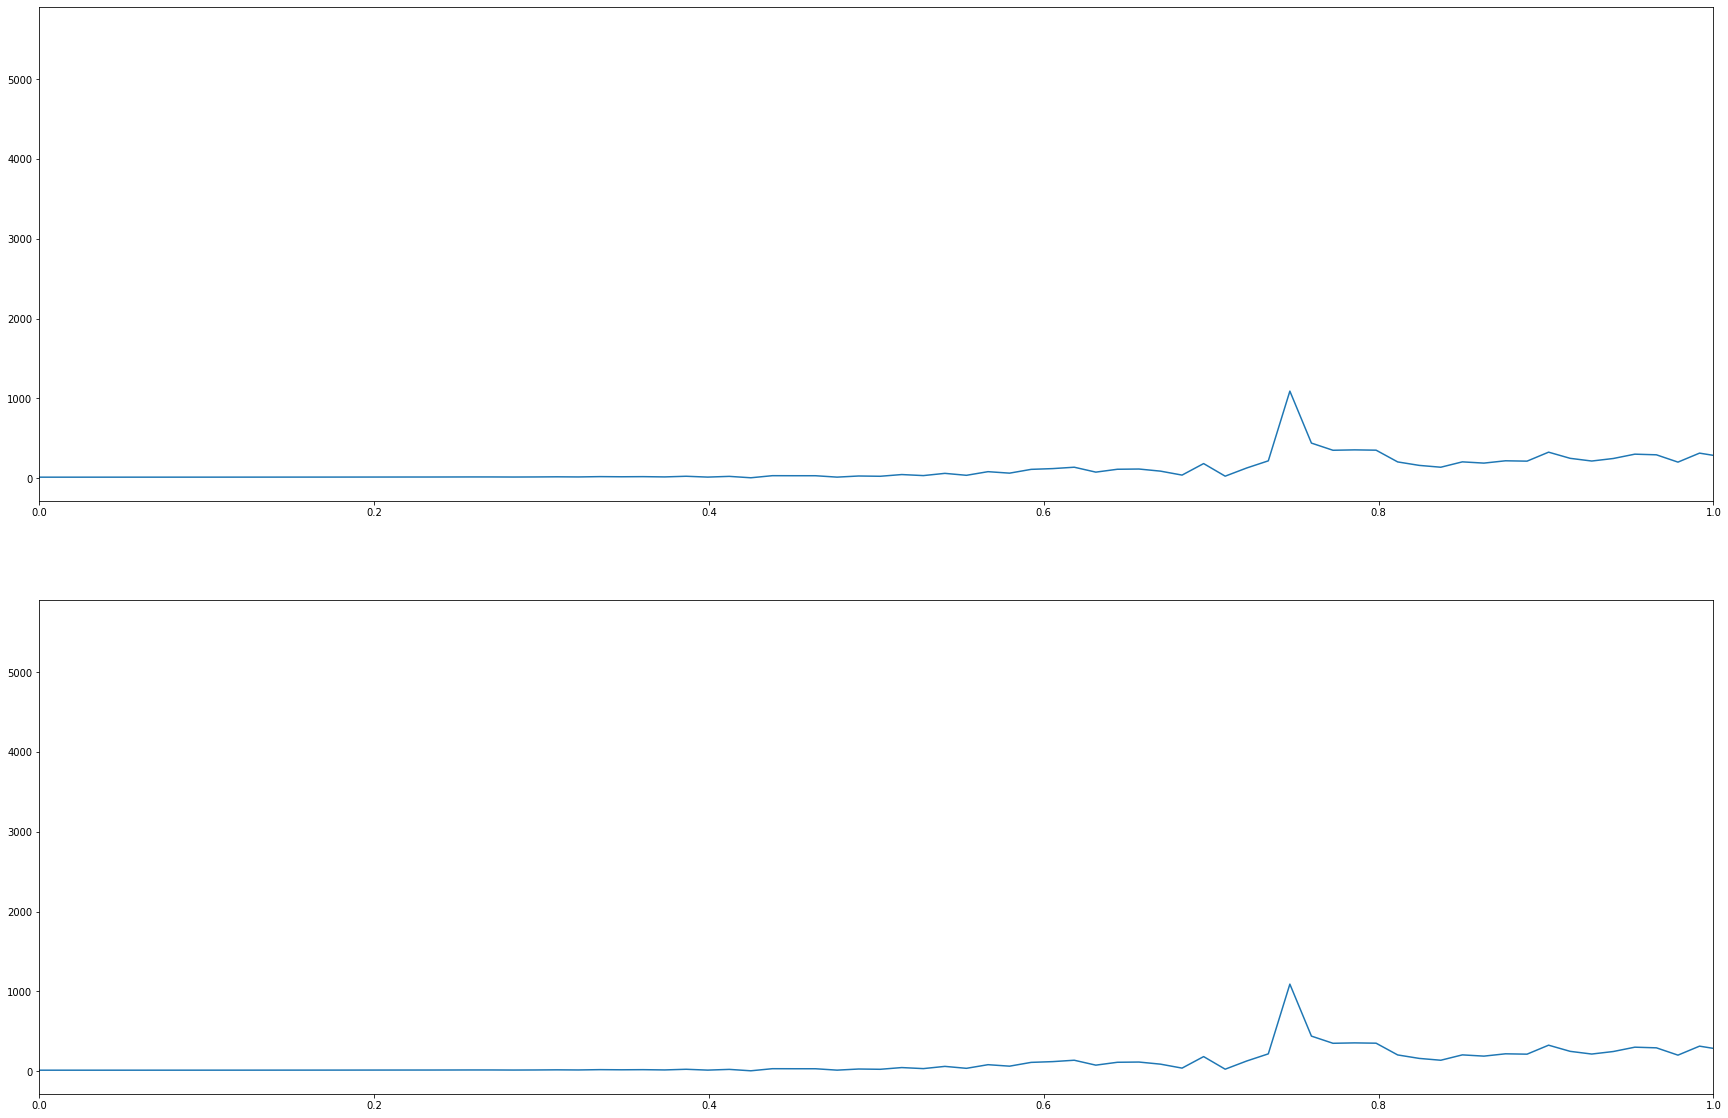

In [12]:
# Plotting Fourier transformed data. Each line represents a collection point (left pocket vs. right pocket).
fig, ax = plt.subplots(2)

matt_rp50_screen_off = process_file('data/matt_rp50_1min_screenoff.csv')
matt_rp50_screen_on = process_file('data/matt_rp50_1min_screeon.csv')

# raw_fft on/off
#ax[0].plot(matt_rp50_screen_off_fft['x'], matt_rp50_screen_off_fft['y'])
ax[0].plot(matt_rp50_screen_on_fft['x'], matt_rp50_screen_on_fft['y'])
ax[0].set_xlim(0, 1)

matt_rp50_screen_off_bw = butterworth(matt_rp50_screen_off)
matt_rp50_screen_on_bw = butterworth(matt_rp50_screen_on)

# bw_fft on_off
#ax[1].plot(matt_rp50_screen_off_bw_fft['x'], matt_rp50_screen_off_bw_fft['y'])
ax[1].plot(matt_rp50_screen_on_bw_fft['x'], matt_rp50_screen_on_bw_fft['y'])
ax[1].set_xlim(0, 1)
